# Sparse Linear Inverse Demo

In this demo, we will illustrate how to use the `vampyre` package for a basic sparse linear inverse problem.  The problem is to estimate a sparse vector $z$ from linear measurements of the form $y=Az+w$ where $w$ is Gaussian noise.  This is the basic problem in compressed sensing. 

## Importing the Package 


First we need to import the `vampyre` package.  Since `python` does not have relative imports, you need to add the path location for the `vampyre` package to the system path.  In this case, we have specified the path use a relative path location, but you can change this depending on where `vampyre` is located.

In [1]:
import os
import sys
vp_path = os.path.abspath('../../')
if not vp_path in sys.path:
    sys.path.append(vp_path)
import vampyre as vp

We will also load the other packages we will use in this demo.  This could be done before the above import.

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generating Synthetic Data

To illustrate the VAMP algorihtm, we will generate synthetic data $z$ and measurements $y$ following a probabilistic sparse model. First, we set the dimensions and the shapes of the vectors we wil use.

In [3]:
# Parameters
ns = 10     # number of samples
nz = 1000   # number of components of z per sample
ny = 500    # number of measurements y per sample

# Compute the shapes
if (ns==1):
    zshape = (nz,)
    yshape = (ny,)
else:
    zshape = (nz,ns)
    yshape = (ny,ns)
Ashape = (ny,nz)

To generate the synthetic data for this demo, we use the following simple probabilistic model.  For the input $z$, we will use Bernouli-Gaussian distribution, a simple commonly used model in sparse signal processing.  In this model, each component $z_i=0$ with probability $1-\rho$ and $z_i \sim {\mathcal N}(0,1)$ with probability $\rho$.  The parameter $\rho$ is called the *sparsity ratio* and is the average number of non-zero components.  When $\rho$ is small, the vector $z$ is sparse.  The components on which $z_i$ are non-zero are called the *active* components.  We set the parameters below.  We also set the SNR for the measurements.

In [4]:
sparse_rat = 0.1   # sparsity ratio
zmean1 = 0         # mean for the active components
zvar1 = 1          # variance for the active components
snr = 30           # SNR in dB

Using these parameters, we can generate random sparse `z` following this distribution with the following simple code.

In [5]:
zmean0 = 0
z1 = np.random.normal(zmean1, np.sqrt(zvar1), zshape)
u = np.random.uniform(0, 1, zshape) < sparse_rat
z = z1*u

To illustrate the sparsity, we plot column of matrix `z`.  Note that if `ns==1`, then `z` only has one column.  We can see from this plot that the majority of the components of `z` are zero.

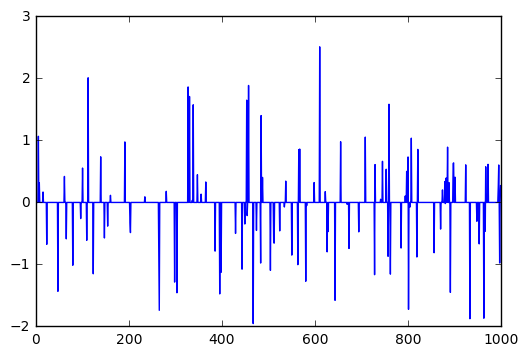

In [6]:
if ns==1:
    zi = z
else:
    zi = z[:,0]
ind = np.array(range(nz))
plt.plot(ind,zi)

Now, we create a random transform $A$ and output $y_0 = Az$.

In [7]:
A = np.random.normal(0, 1/np.sqrt(nz), Ashape)
y0 = A.dot(z)

Finally, we add noise at the desired SNR

In [8]:
yvar = np.mean(np.abs(y0)**2)
wvar = yvar*np.power(10, -0.1*snr)
y = y0 + np.random.normal(0,np.sqrt(wvar), yshape)

## Creating the Vampyre estimators

Now that we have created the sparse data, we will use the `vampyre` package to recover `z` from `y`.  In `vampyre` the methods to perform this estimation are called *solvers*.  For this demo, we will use a simple solver called VAMP described in the paper:

* Rangan, Sundeep, Philip Schniter, and Alyson Fletcher. "Vector approximate message passing." arXiv preprint arXiv:1610.03082 (2016).


Similar to most of the solvers in the `vampyre` package, the VAMP solver needs precise specifications of the probability distributions of `z` and `y`.  These densities are described by *estimators*.  We first describe the prior $p(z)$.  The `vampyre` package will eventually have a large number of estimators to describe various densities.  In this simple demo, $p(z)$ is what is called a *mixture* distribution since $z$ is one distribution with probability $1-\rho$ and a second distribution with probability $\rho$.  To describe this mixture distribution in the `vampyre` package, we need to create estimator classes for each distribution.  This is done with the following code which creates an estimator `est0` for a discrete distribution with a point mass at 0 and `est1` for the Gaussian distribution with the active components.

In [9]:
est0 = vp.estim.DiscreteEst(0,1,zshape)
est1 = vp.estim.GaussEst(zmean1,zvar1,zshape)

We next use the `vampyre` class, `MixEst` to describe a mixture of the two distributions.  This is done by creating a list, `est_list`, of the estimators and an array `pz` with the probability of each component.

In [10]:
est_list = [est0, est1]
pz = np.array([1-sparse_rat, sparse_rat])
est_in = vp.estim.MixEst(est_list, w=pz)

Next, we describe the likelihood function, $p(y|z)$.  Since $y=Az+w$, we can first use the `MatrixLT` class to define a linear transform operator `Aop` corresponding to the matrix `A`.  Then, we use the `LinEstim` class to describe the likelihood $y=Az+w$.

In [11]:
Aop = vp.trans.MatrixLT(A,zshape)
est_out = vp.estim.LinEstim(Aop,y,wvar,map_est=False)

Finally, the VAMP method will need a variance handler which describes how to process the variance terms for message passing and other cost calculations.  For most applications, you can just use the simple variance handler.

In [12]:
var_hdl = vp.estim.VarHdlSimp(map_est=False, shape=zshape)

## Running the VAMP Solver

Having described the input and output estimators and the variance handler, we can now construct a solver and run the solver.  We have supplied the solver constructor an optional parameter `hist_list` which will be described momentarily.  The paramter `nit` is the number of iterations.  This is fixed for now.  Later, we will add auto-termination.

In [13]:
nit = 20  # number of iterations
solver = vp.solver.Vamp(est_in,est_out,var_hdl, hist_list=['z2', 'zvar2'],nit=nit)
solver.solve()

The VAMP solver computes two estimates, `z1` and `z2`.  At convergence, these should be close to one another.  We can look at one of them, say `z2` and plot it compared to the true `z`.  We will plot column 0 of the `z` and its estimate `z2`.  You should see a very good match.

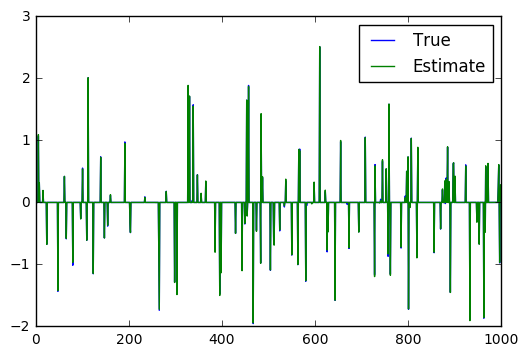

In [14]:
z2 = solver.z2
if ns==1:
    zi = z
    z2i = z2
else:
    zi = z[:,0]
    z2i = z2[:,0]
ind = np.array(range(nz))
plt.plot(ind,zi)
plt.plot(ind,z2i)
plt.legend(['True', 'Estimate'])

We can measure the normalized mean squared error as follows.  The VAMP solver also produces an estimate of the MSE in the variable `zvar2`.  We can extract this variable to compute the predicted MSE.  We see that the normalized MSE is indeed low and closely matches the predicted value from VAMP.

In [15]:
zerr = np.mean(np.abs(z2-z)**2)
zvar2 = solver.zvar2
zpow = np.mean(np.abs(z)**2)
mse_act = 10*np.log10(zerr/zpow)
mse_pred = 10*np.log10(zvar2/zpow)
print("Normalized MSE (dB): actual {0:f} pred {1:f}".format(mse_act, mse_pred))

Normalized MSE (dB): actual -34.741596 pred -34.835690


Finally, we can plot the actual and predicted MSE as a function of the iteration number.  When `solver` was contructed, we passed an argument `hist_list=['z2', 'zvar2']`.  This indicated to store the value of the estimate `z2` and predicted error variance `zvar2` with each iteration.  We can recover these values from `solver.hist_dict`, the history dictionary.  Using the values we can compute and plot the normalized MSE on each iteartion.  We see that VAMP gets a low MSE in very few iterations, about 10.

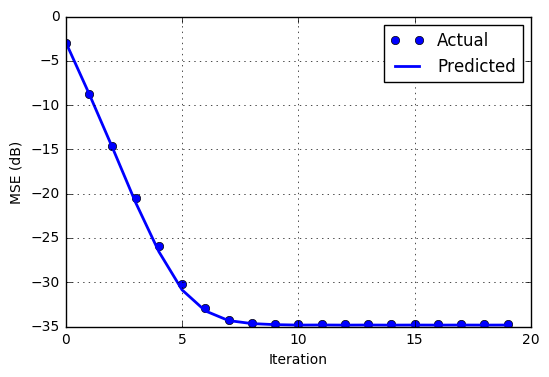

In [16]:
# Compute the MSE as a function of the iteration
z2_hist = solver.hist_dict['z2']
zvar2_hist = solver.hist_dict['zvar2']
nit = len(z2_hist)
mse_act = np.zeros(nit)
mse_pred = np.zeros(nit)
for it in range(nit):
    zerr = np.mean(np.abs(z2_hist[it]-z)**2)
    zvar2 = zvar2_hist[it]
    mse_act[it] = 10*np.log10(zerr/zpow)
    mse_pred[it] = 10*np.log10(zvar2/zpow)
    
plt.plot(range(nit), mse_act, 'bo', linewidth=2)
plt.plot(range(nit), mse_pred, 'b-', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('MSE (dB)')
plt.legend(['Actual', 'Predicted'])
plt.grid()